## Blood smear length determination project

Task: To find the length of the blood smear from the input image.

Appraoch to the task:

1. Overall image analysis:
- To analyze the edges and color distribution of the image, we used Canny edge detection with Gaussian blur for noise reduction. This step preserves fine edges while eliminating noise.
- Additionally, a bilateral filter was applied to further smooth the image while maintaining edge integrity.
- The image was then converted from BGR to HSV format and split into Hue, Saturation, and Value channels to examine color distribution effectively.

2. For overall contour detection of the blood smear, following approach was followed:
Preprocessing: Uses CLAHE for contrast enhancement and Laplacian filtering for sharpening.
Method 1 - Canny Edge Detection: Highlights fine edges using gradient-based detection.
Method 2 - Thresholding & Morphology: Extracts the smear region using binary segmentation and gap filling.
Merging Both Approaches: Combines Canny and thresholding using bitwise OR operation to improve edge accuracy.
Detection & Visualization: Detects the blood smear boundaries and overlays them on the original image.



Then, different approach for lower and upper point detection were used due to their varying charateristics:

Lower edge detection:
1. Approach 1:
- Converts the image to grayscale, applies Gaussian blur for noise reduction, and uses binary thresholding to highlight the smear.
- Using morphological opening and closing transformations to identify contours, filtering out small, irrelevant ones based on area.
- Draw detected contour on original image.

2. Approach 2:
- Noise is reduced using morphological opening and median blur.
- Identifies the topmost, bottommost, and midpoint pixels on the smear’s edge and marks a common pixel for visualization.
- Uses fixed threshold and apply a binary mask over noise reduced image (achieved by Gaussian blur).
- Identifies the largest contour and fills small gaps with morphological closing.


Upper edge detection:
1. Approach 1:
- Detects sharp edges in an image by applying contrast enhancement (CLAHE) and sharpening (Laplacian filter) before using Canny edge detection, which focuses on highlighting distinct and prominent features while ignoring gradual changes, then contours from the sharp edges are identified and overlayed on the original image.

2. Approach 2:
- Define a ROI for processing, then improves contrast, brightness, color, and sharpness using the PIL library to highlight the edges. Uses Canny edge detection to find edges in the grayscale image and then identify contour from edges.
-Checks for exact intersections with the horizontal line.
- If no intersections are found, it calculates the closest point.
- Marks exact intersections with different to ensure differentiation.



Now, in order to combine these images with lower and upper point separately detected for the blood smear, the individual images of upper and lower edge detected by blending them into one with appropriate weights.
But, it doesn't seemed to be that much accurate.


Hence, the finalised approach for the task followed is given below:

## Importing necessary librabries: 


In [19]:
import cv2
import os
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

### Function for Upper Point of the smear:

In [20]:
def Up_Edge_Detector(image_path, x_range=(100, 1000), y_range=(300, 1350), line_y=550):
    """
    Detects the upper edge intersection or nearest point with a specified horizontal line in an image.
    
    Parameters:
        image_path (str): Path to the input image.
        x_range (tuple): The x-coordinate range for cropping the ROI.
        y_range (tuple): The y-coordinate range for cropping the ROI.
        line_y (int): The y-coordinate of the horizontal line to detect intersections.
        
    Returns:
        tuple: Coordinates of the exact intersection point (if found) and the closest point (if no exact match).
        marked_original_image (ndarray): Original image marked with the intersection or nearest point.
    """

    # Load the image from the specified path
    image = cv2.imread(image_path)
    
    # Crop the region of interest (ROI) based on given x and y ranges
    x_start, x_end = x_range
    y_start, y_end = y_range
    roi = image[y_start:y_end, x_start:x_end]
    
    # Convert the cropped ROI to a PIL image for enhancement
    roi_pil = Image.fromarray(roi)
    
    # Apply image enhancements to improve contrast, brightness, color saturation, and sharpness
    image_enhanced = ImageEnhance.Contrast(roi_pil).enhance(4.5)   # Boost contrast
    image_enhanced = ImageEnhance.Brightness(image_enhanced).enhance(1.45)  # Increase brightness
    image_enhanced = ImageEnhance.Color(image_enhanced).enhance(2.0)  # Enhance color intensity
    image_enhanced = ImageEnhance.Sharpness(image_enhanced).enhance(2.0)  # Sharpen the image
    
    # Convert the enhanced image back to OpenCV format
    modified_image_cv = np.array(image_enhanced)
    
    # Convert the enhanced image to grayscale
    gray_image = cv2.cvtColor(modified_image_cv, cv2.COLOR_RGB2GRAY)  
    
    # Detect edges using the Canny edge detection algorithm
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    
    # Find contours from the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Prepare images for marking the results
    intersection_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Colored version of edges for visualization
    marked_original_image = image.copy()  # Copy of the original image for marking points
    
    # Initialize variables to store detected points
    x_up, y_up = None, None  # Exact intersection point
    x_up_near, y_up_near = None, None  # Closest point to the line if no intersection found
    min_distance = float('inf')  # Minimum distance to the target line

    # Loop through contours and their points to find intersections or closest points
    for contour in contours:
        for point in contour:
            x, y = point[0]  # Extract coordinates from the contour point
            
            if y == line_y:  # Check for exact intersection with the horizontal line
                x_up, y_up = x + x_start, y + y_start  # Adjust coordinates to the original image
                cv2.circle(intersection_image, (x, y), 10, (255, 0, 0), -1)  # Mark on the edge image (red dot)
                cv2.circle(marked_original_image, (x_up, y_up), 10, (0, 255, 0), -1)  # Mark on the original image (green dot)
            else:
                # Calculate distance to the horizontal line if not intersecting
                distance = abs(y - line_y)
                if distance < min_distance:
                    min_distance = distance
                    x_up_near, y_up_near = x + x_start, y + y_start  # Update closest point

    # Mark the closest point on the original image if no exact intersection was found
    if x_up_near is not None and y_up_near is not None:
        cv2.circle(marked_original_image, (x_up_near, y_up_near), 10, (0, 0, 255), -1)  # Blue dot for the nearest point

    # Return both the intersection and nearest points along with the marked image
    return (x_up, y_up), (x_up_near, y_up_near), marked_original_image


### Function for Lower Point of the smear:

In [21]:
def Low_Edge_Detector(image_path, threshold_value=91, min_contour_area=111111):
    """
    Detects the lower edge of a blood smear.
    
    Parameters:
        image_path (str): Path to the input image.
        threshold_value (int): Threshold value for binary inversion.
        min_contour_area (int): Minimum contour area to consider for detection.
        
    Returns:
        tuple: Coordinates (x, y) of the detected common pixel (left edge).
    """

    # Load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary inversion thresholding to highlight dark regions
    _, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)

    # Noise reduction using morphological opening and median blur
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)  # Removes small noise and smooths edges
    binary = cv2.medianBlur(binary, 3)  # Further reduces noise by averaging pixel values

    # Find contours from the binary mask
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw filtered contours
    mask = np.zeros_like(binary)
    for contour in contours:
        # Filter contours based on the minimum area to eliminate small, irrelevant ones
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)  # Fill the contour on the mask

    # Compute the vertical projection to find columns containing smear pixels
    vertical_projection = np.sum(mask, axis=0)  # Sum pixel values along the vertical axis
    nonzero_columns = np.where(vertical_projection > 0)[0]  # Identify columns with non-zero projection

    # Handle the case where no smear is detected
    if len(nonzero_columns) == 0:
        print(f"Smear not detected in {image_path}.")
        return None

    # Create a final mask for the selected contour area
    final_mask = np.zeros_like(mask)
    for contour in contours:
        # Again filter out small contours based on the minimum area
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(final_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Detect the left edge pixels in the final mask
    left_edge_pixels = np.zeros_like(final_mask)
    for i in range(final_mask.shape[0]):
        leftmost_pixel = np.argmax(final_mask[i, :])  # Find the leftmost pixel in the current row
        # Mark the detected left edge pixel if it exists
        if final_mask[i, leftmost_pixel] > 0:
            left_edge_pixels[i, leftmost_pixel] = 255

    # Extract coordinates of the detected edge pixels
    edge_pixels = np.column_stack(np.where(left_edge_pixels > 0))
    if len(edge_pixels) > 0:
        # Calculate the midpoint of the detected edge pixels
        midpoint_y, midpoint_x = np.mean(edge_pixels, axis=0).astype(int)
    else:
        print(f"No edge pixels found in {image_path}.")
        return None

    # Identify the common pixel at the calculated midpoint
    common_pixel_x = np.argmax(final_mask[midpoint_y, :])
    if final_mask[midpoint_y, common_pixel_x] > 0:
        common_pixel = (midpoint_y, common_pixel_x)
    else:
        print(f"No common pixel found in {image_path}.")
        return None

    # Visualize the detected common pixel on the final mask
    marked_left_edge = cv2.circle(final_mask, (common_pixel[1], common_pixel[0]), 10, (0, 0, 255), -1)

    # Return the coordinates of the detected common pixel
    return common_pixel[1], common_pixel[0]


## Combining the images:
- Coordinates of the necessary points are extracted using the 2 functions as shown above, which are then plotted onto the original image
- As the upper point was not detected very accurately is some images, hence to make the length more robust it takes an average of the exact and nearest point detected with reference to the lower edge point.
- Also, it shows a visual representation of the length with the pixels used for better judgement by the user.

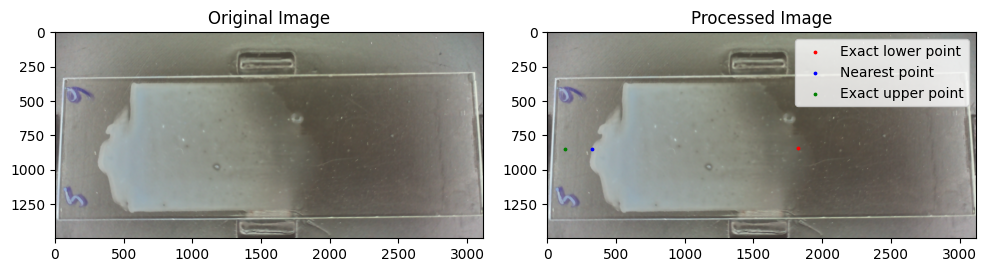

Nearest upper intersection point: (323, 850)
Exact upper point: (128, 851)
Exact lower point: (840, 1822)
Blood smear length: 1204.0701806788506 pixels
Exact(green) smear length: 1204.0701806788506 pixels
Near(blue) smear length: 1100.9418694917547 pixels


In [27]:
# Define the image path
Img_path = "E:\\Proj-Agraj\\smears\\83.bmp"

# Load the original image
img = cv2.imread(Img_path)

# Detect the lower edge using the Low_Edge_Detector function
LOW = Low_Edge_Detector(Img_path, threshold_value=91, min_contour_area=111111)

# Detect the upper edge and intersections using the Up_Edge_Detector function
(x_up, y_up), (x_up_near, y_up_near), UPP = Up_Edge_Detector(Img_path, x_range=(100, 1000), y_range=(300, 1350), line_y=550)

# Extract the coordinates of the lower edge from the detection result
x_low = int(LOW[1])
y_low = int(LOW[0])

# Plotting the original and processed images
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Display the original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("on")

# Display the processed image with the detected points
axes[1].imshow(img)
axes[1].scatter(y_low, x_low, color='red', label='Exact lower point', s=3)  # Mark the common pixel
axes[1].scatter(x_up, y_up, color='blue', label='Nearest point', s=3)  # Mark the common pixel
axes[1].scatter(x_up_near, y_up_near, color='green', label='Exact upper point', s=3)  # Mark the common pixel

axes[1].set_title("Processed Image")
axes[1].legend()
axes[1].axis("on")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Print the detected points
print(f"Nearest upper intersection point: ({x_up}, {y_up})")
print(f"Exact upper point: ({x_up_near}, {y_up_near})")
print(f"Exact lower point: ({x_low}, {y_low})")

# Calculate smear lengths based on detected points
Near_Smear_length = np.sqrt((x_up - x_low) ** 2 + (y_up - y_low) ** 2)
First_Smear_length = np.sqrt((x_up_near - x_low) ** 2 + (y_up_near - y_low) ** 2)

# Choose the final smear length based on point availability
if (x_up_near, y_up_near) != (None, None):
    Smear_length = First_Smear_length
else:
    print("No exact intersection point found.")
    Near_Smear_length = np.sqrt((x_up - x_low) ** 2 + (y_up - y_low) ** 2)
    Smear_length = (First_Smear_length + Near_Smear_length) / 2
    print(f"Near smear length: {Near_Smear_length} pixels")

# Print the calculated smear lengths
print(f"Blood smear length: {Smear_length} pixels")
print(f"Exact(green) smear length: {First_Smear_length} pixels")
print(f"Near(blue) smear length: {Near_Smear_length} pixels")


Now, in order to convert this length from pixels to real world readable format, we can assign a reference length (eg- length of glass slide to be 5cm) and then convert the smear legnth from pixels to centimeters.

### The model was found to be working for 125+ images out of 145 total images used for the training and testing of the hyperparameters.